Датасет о 1215 покемонах и их характеристиках. <br>
В датасете представлены следующие атрибуты:
- images: Путь к изображению покемона (строковой тип. В данной работе не используется)
- index: Номер покемона в Покедексе (числовой тип. Был удалён из датасета, так как используется стандартная индексация).
- Name: Название Покемона (строковой тип).
- Type 1: Первый из типов Покемона (строковой тип).
- Type 2: Второй из типов Покемона, если присутствует (строковой тип).
- Total: Сумма всех характеристик Покемона (числовой тип).
- HP: Очки здоровья Покемона (числовой тип).
- Attack: Показатель базовой атаки Покемона для обычных атак (числовой тип).
- Defense: Базовый показатель защиты Покемона от обычных атак (числовой тип).
- SP. Atk.: Показатель базовой атаки Покемона для особых атак (числовой тип).
- SP. Def.: Базовый показатель защиты Покемона от особых атак (числовой тип).
- Speed: Определяет, какой Покемон атакует первым в раунде (числовой тип).

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans

df = pd.read_csv('pokedex.csv')
#Удаляем столбец image за ненадобностью
df.drop('Image', axis=1, inplace=True)
#Удаляем столбец index за ненадобностью
df.drop('Index', axis=1, inplace=True)
df


,Name,Type 1,Type 2,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,Venusaur Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,Charmander,Fire,NaN,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...,...,...
1210,Iron Crown,Steel,Psychic,590,90,72,100,122,108,98
1211,Terapagos Normal Form,Normal,NaN,450,90,65,85,65,85,60
1212,Terapagos Terastal Form,Normal,NaN,600,95,95,110,105,110,85
1213,Terapagos Stellar Form,Normal,NaN,700,160,105,110,130,110,85


Проверяем на нулевые значения

In [59]:
df.isnull().sum()

Name          0
Type 1        0
Type 2      546
Total         0
HP            0
Attack        0
Defense       0
SP. Atk.      0
SP. Def       0
Speed         0
dtype: int64

Так как пустые значения только в столбце Type 2, это значит, что второй тип отсутствует. Заменяем пропущенные значения на 'None'

In [60]:
df.fillna({'Type 2':'None'}, inplace=True)
df

,Name,Type 1,Type 2,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,Venusaur Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,Charmander,Fire,None,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...,...,...
1210,Iron Crown,Steel,Psychic,590,90,72,100,122,108,98
1211,Terapagos Normal Form,Normal,None,450,90,65,85,65,85,60
1212,Terapagos Terastal Form,Normal,None,600,95,95,110,105,110,85
1213,Terapagos Stellar Form,Normal,None,700,160,105,110,130,110,85


Проверяем дубликаты

In [61]:
df.duplicated().sum()

0

Добавляем новый столбец - среднее значение показателей Покемона

In [62]:
df['Avg'] = df[['HP','Attack','Defense','SP. Atk.','SP. Def','Speed']].mean(axis=1)
df.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed,Avg
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,53.000000
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,67.500000
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,87.500000
3,Venusaur Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,104.166667
4,Charmander,Fire,None,309,39,52,43,60,50,65,51.500000


In [63]:
numdf = df.select_dtypes(include=[np.number])

С помощью графиков проверяем наличие выбросов

Text(0.5, 0, 'Attributes')

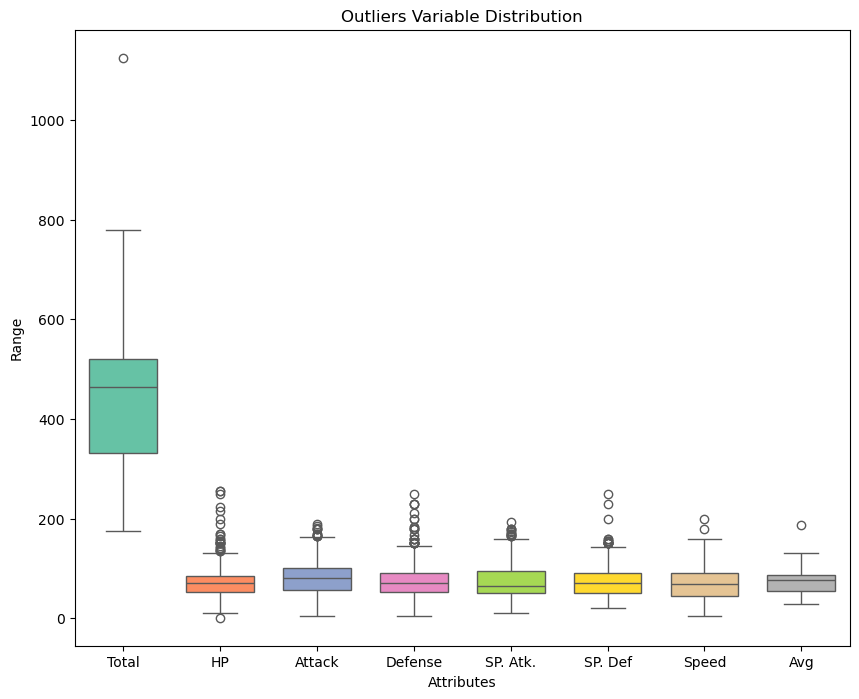

In [64]:
attributes = list(numdf.columns)
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution")
plt.ylabel("Range")
plt.xlabel("Attributes")

Удаляем выбросы из датасета

In [65]:
for i in list(numdf.columns):
    Q1=df[i].quantile(.25)
    Q3=df[i].quantile(.75)
    InterQ=Q3-Q1
    Q1-=InterQ*1.5
    Q3+=InterQ*1.5
    df = df[(df[i] >= Q1) & (df[i] <= Q3)]
df

,Name,Type 1,Type 2,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed,Avg
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,53.000000
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,67.500000
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,87.500000
3,Venusaur Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,104.166667
4,Charmander,Fire,None,309,39,52,43,60,50,65,51.500000
...,...,...,...,...,...,...,...,...,...,...,...
1208,Raging Bolt,Electric,Dragon,590,125,73,91,137,89,75,98.333333
1209,Iron Boulder,Rock,Psychic,590,90,120,80,68,108,124,98.333333
1210,Iron Crown,Steel,Psychic,590,90,72,100,122,108,98,98.333333
1211,Terapagos Normal Form,Normal,None,450,90,65,85,65,85,60,75.000000


Было удалено 79 строчек с выбросами

Text(0.5, 0, 'Attributes')

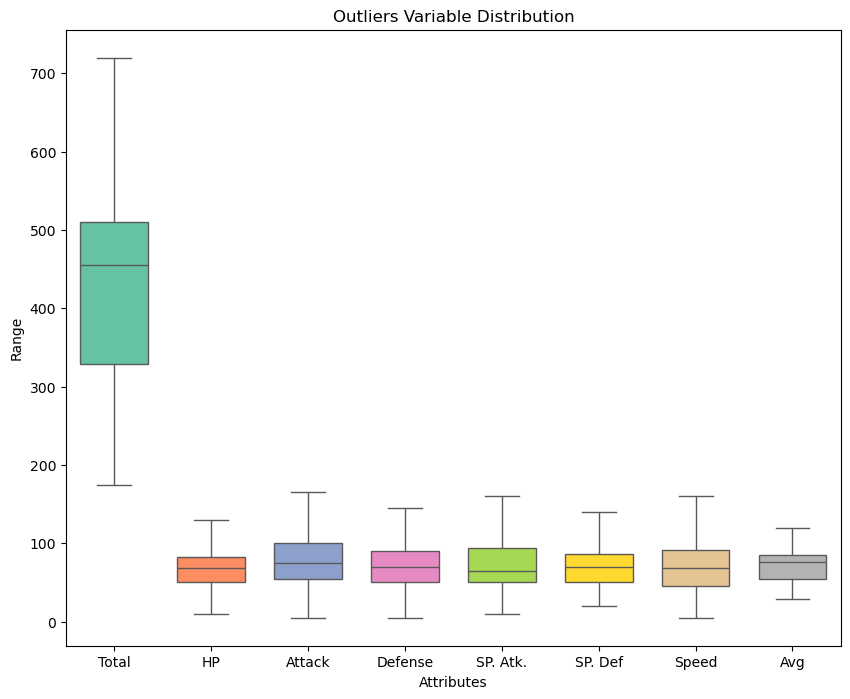

In [66]:
attributes = list(numdf.columns)
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution")
plt.ylabel("Range")
plt.xlabel("Attributes")

In [67]:
numdf = df.select_dtypes(include=[np.number])

Построим графики рассеивания для всех пар атрибутов

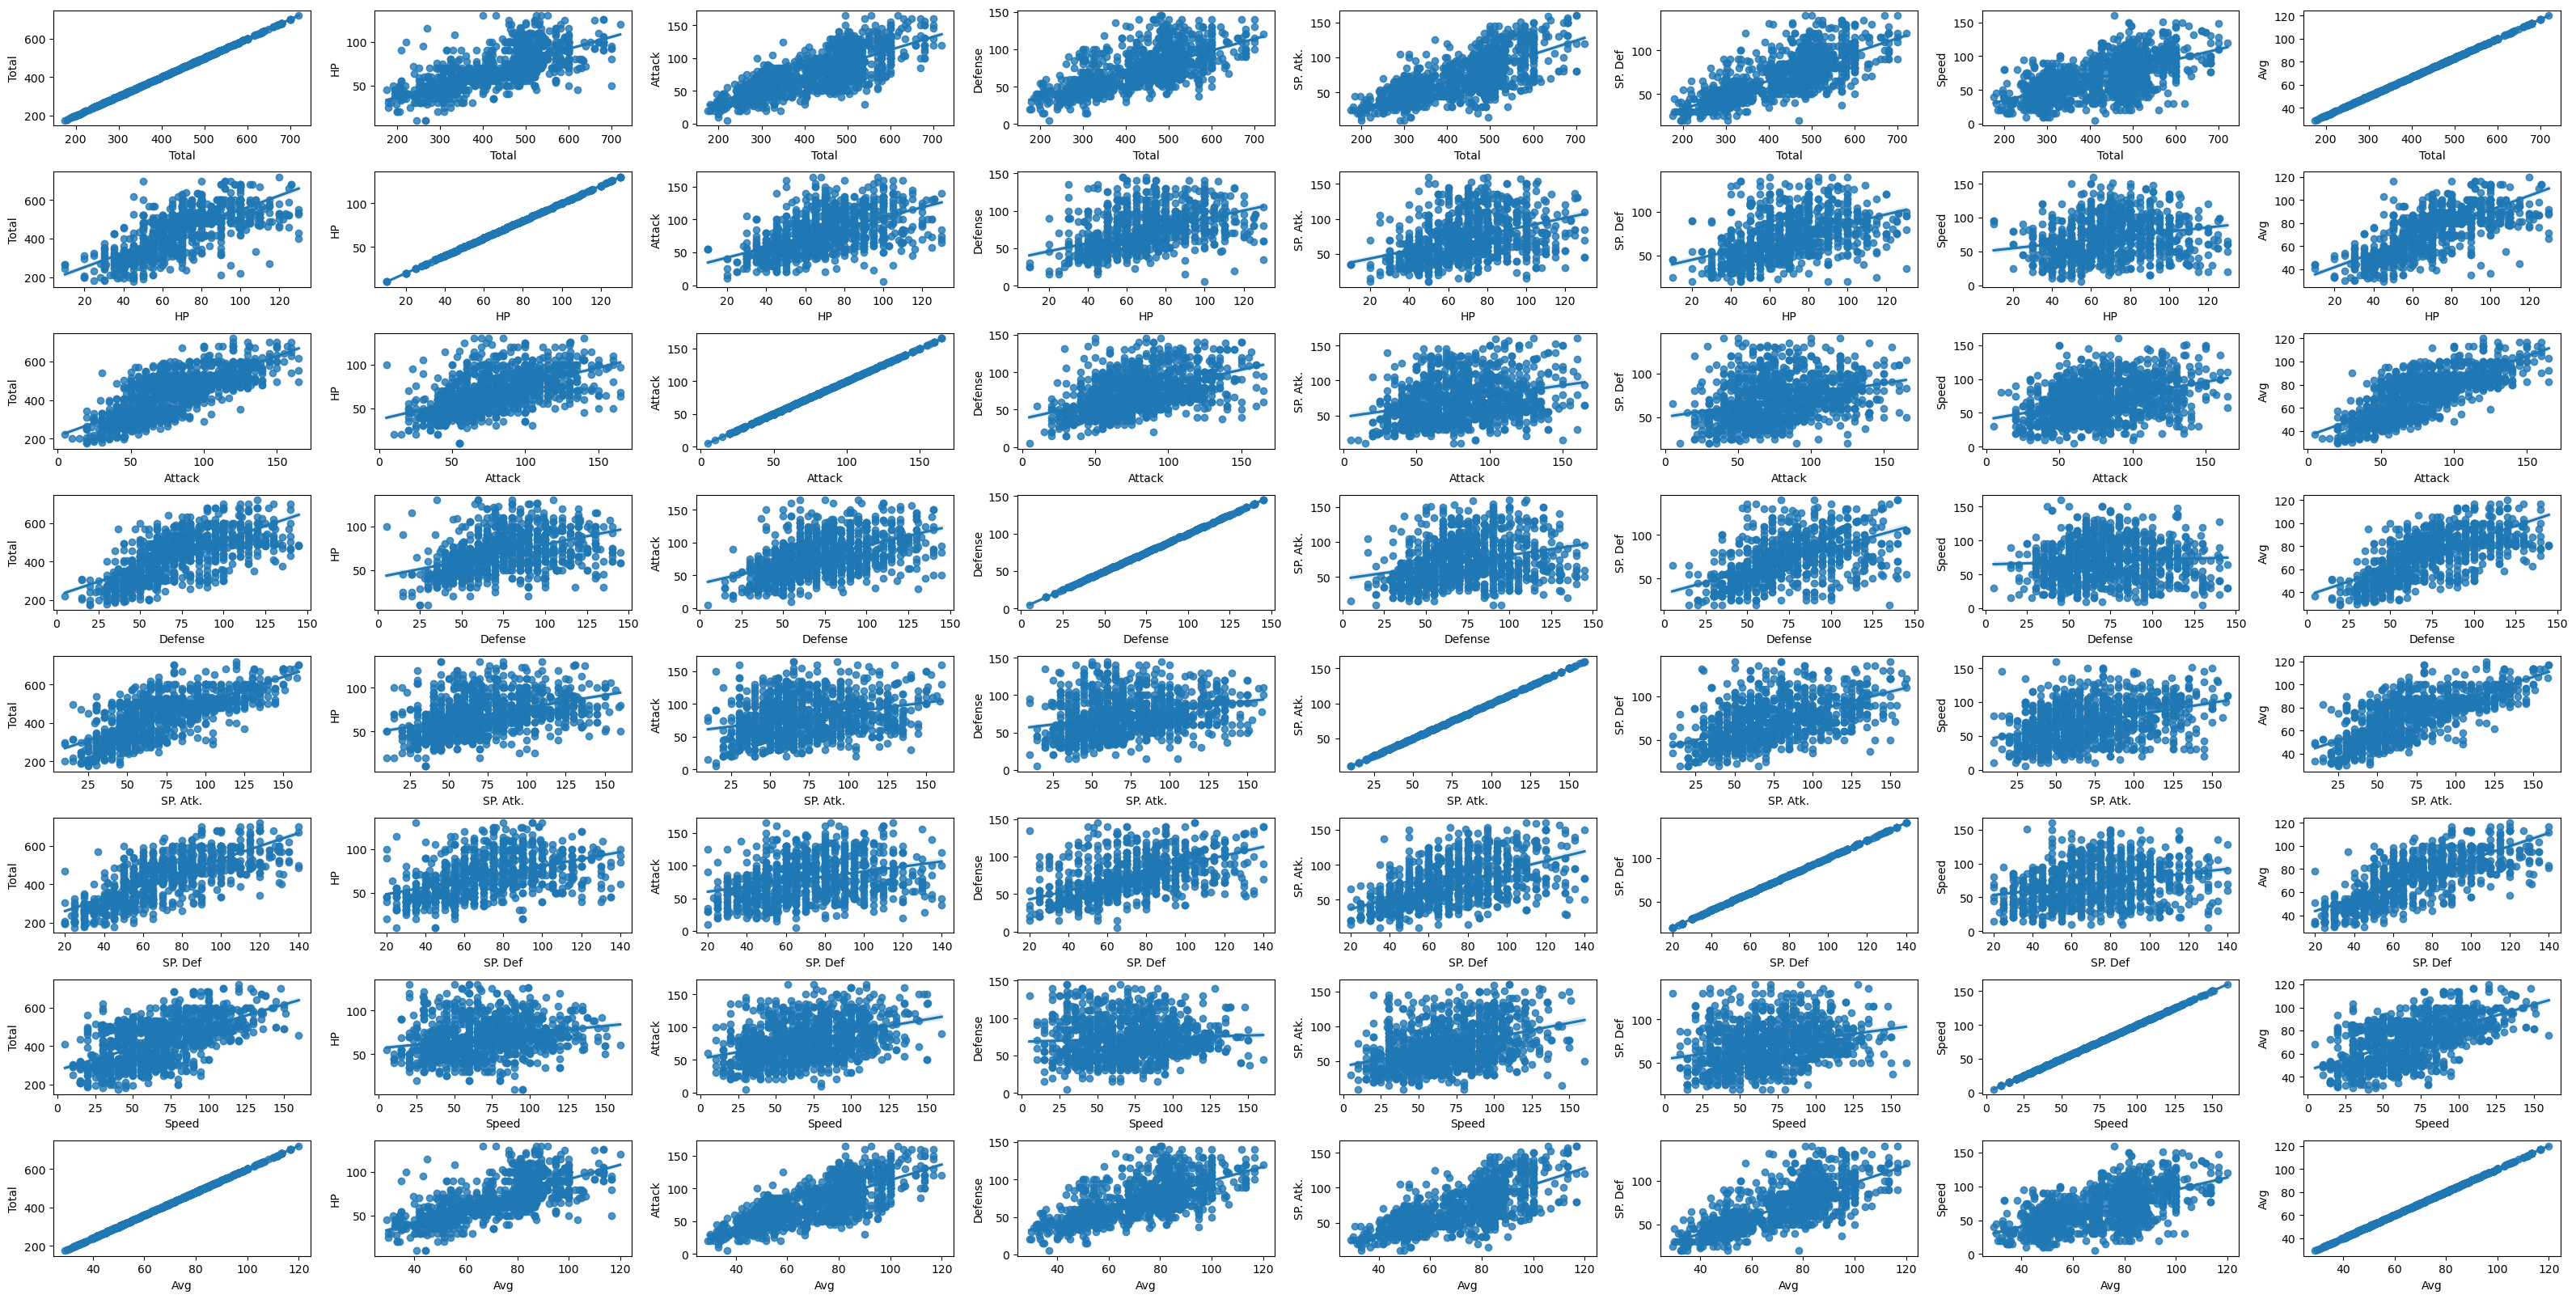

In [68]:
plt.figure(1, figsize=(40, 20))
n = 0
for x in list(numdf.columns):
    for y in list(numdf.columns):
        n += 1
        plt.subplot(8, 8, n)
        plt.subplots_adjust(hspace = 0.4, wspace = 0.25)
        sns.regplot(x = x, y = y, data = df)
plt.show()

Можно заметить, что графики для пар атрибутов с Total и графики для пар атрибутов с Avg идентичны. <br>
Возьмём 6 пар атрибутов, где приблизительно можно увидеть кластеры и применим к ним алгоритм кластеризации K-Means

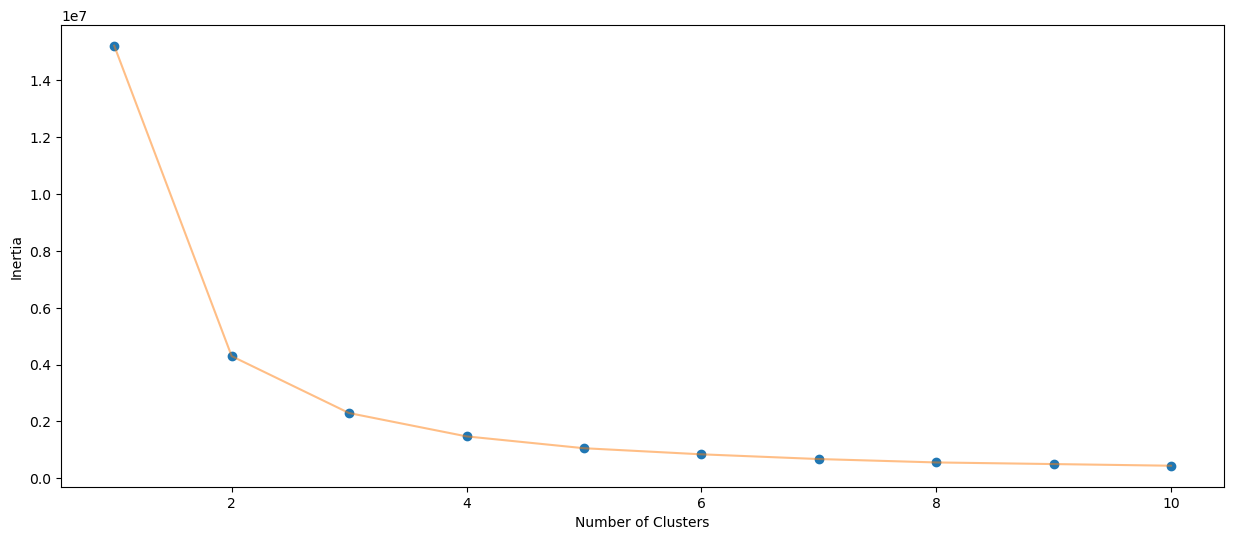

In [69]:
X1 = df[['Total', 'HP']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='lloyd') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

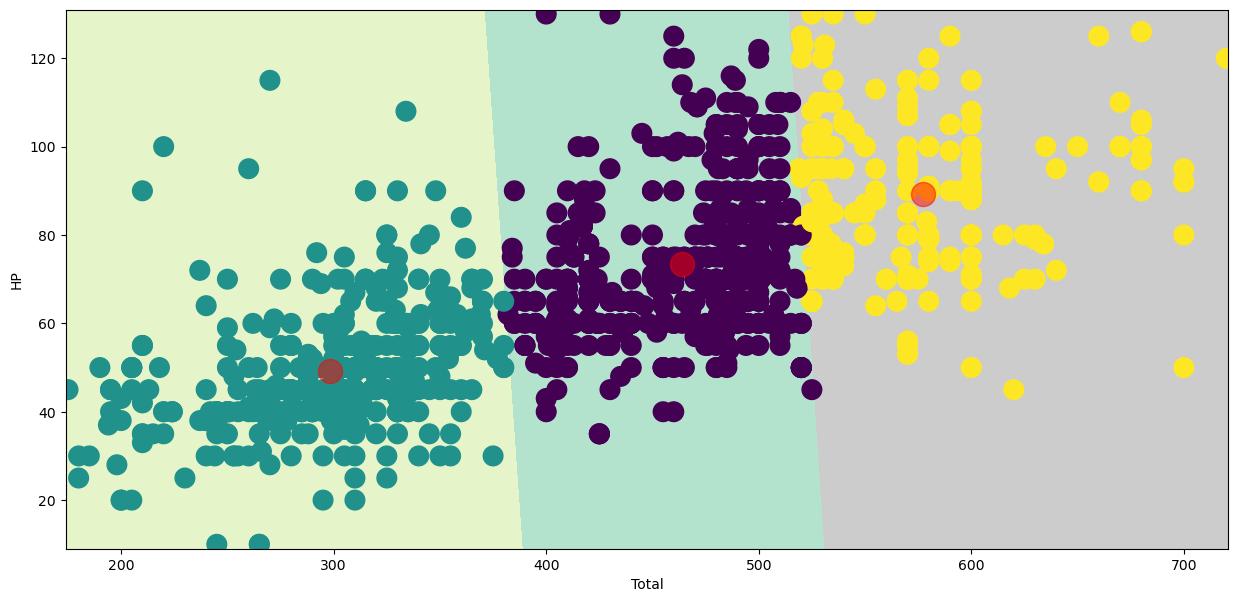

In [70]:
algorithm = (KMeans(n_clusters = 3, init='k-means++', n_init = 10, max_iter = 300,
                        tol=0.0001,  random_state= 111, algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x='Total', y ='HP', data = df, c = labels1, s = 200)
plt.scatter(x = centroids1[: , 0], y = centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Total')
plt.ylabel('HP')
plt.show()

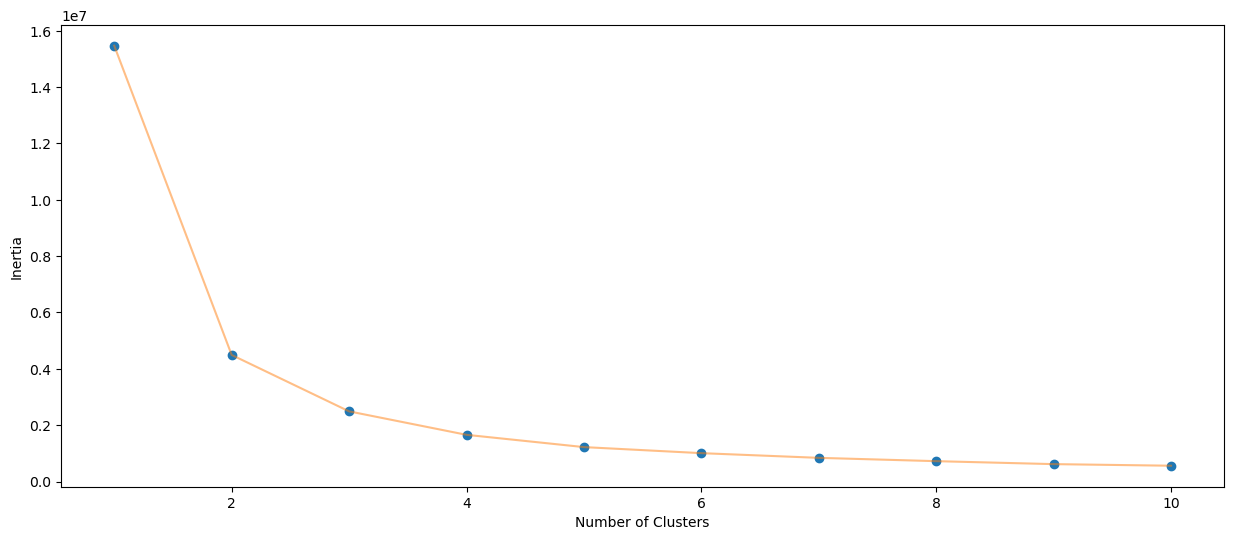

In [71]:
X2 = df[['Defense', 'Total']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='lloyd') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

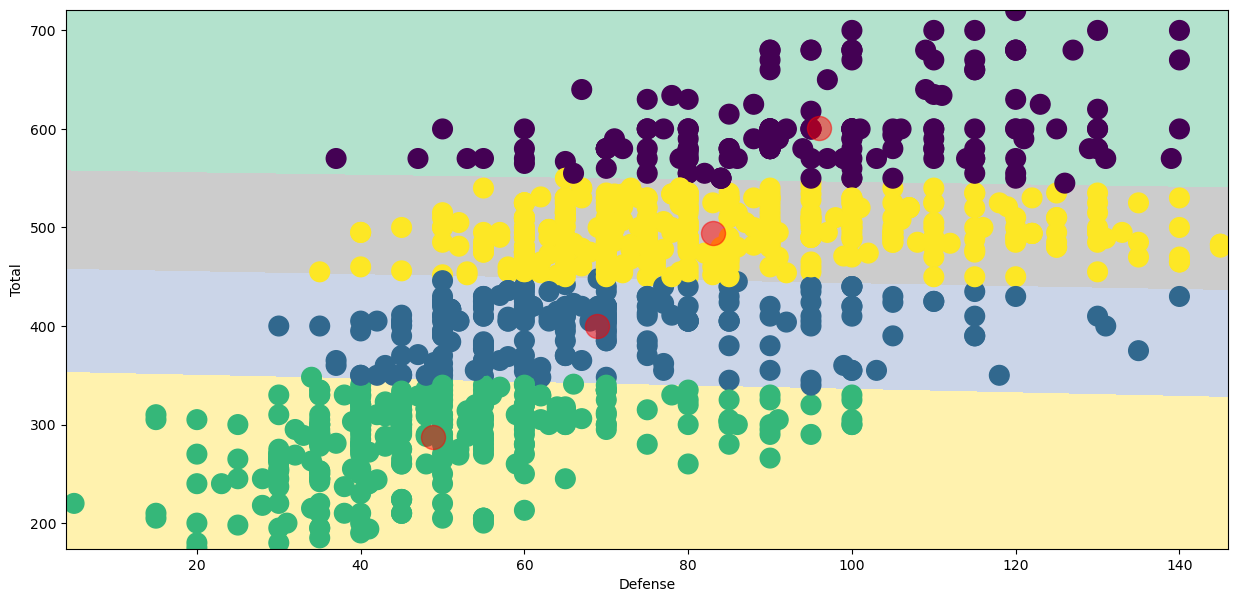

In [72]:
algorithm = (KMeans(n_clusters = 4, init='k-means++', n_init = 10, max_iter = 300,
                        tol=0.0001,  random_state= 111, algorithm='elkan') )
algorithm.fit(X2)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x='Defense', y ='Total', data = df, c = labels1, s = 200)
plt.scatter(x = centroids1[: , 0], y = centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Defense')
plt.ylabel('Total')
plt.show()

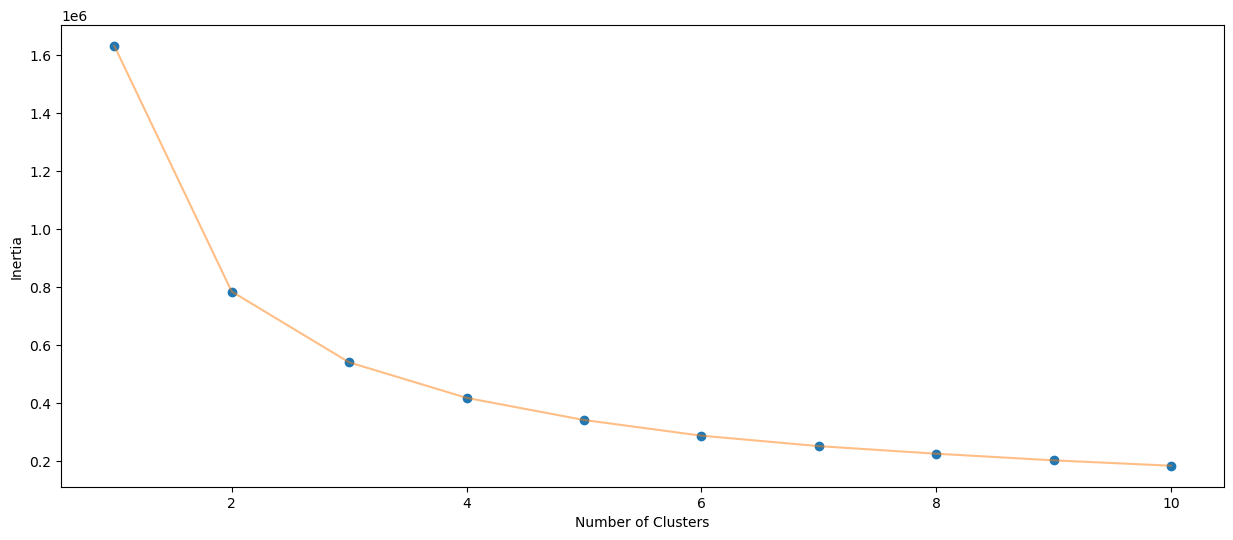

In [73]:
X3 = df[['HP', 'SP. Atk.']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='lloyd') )
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

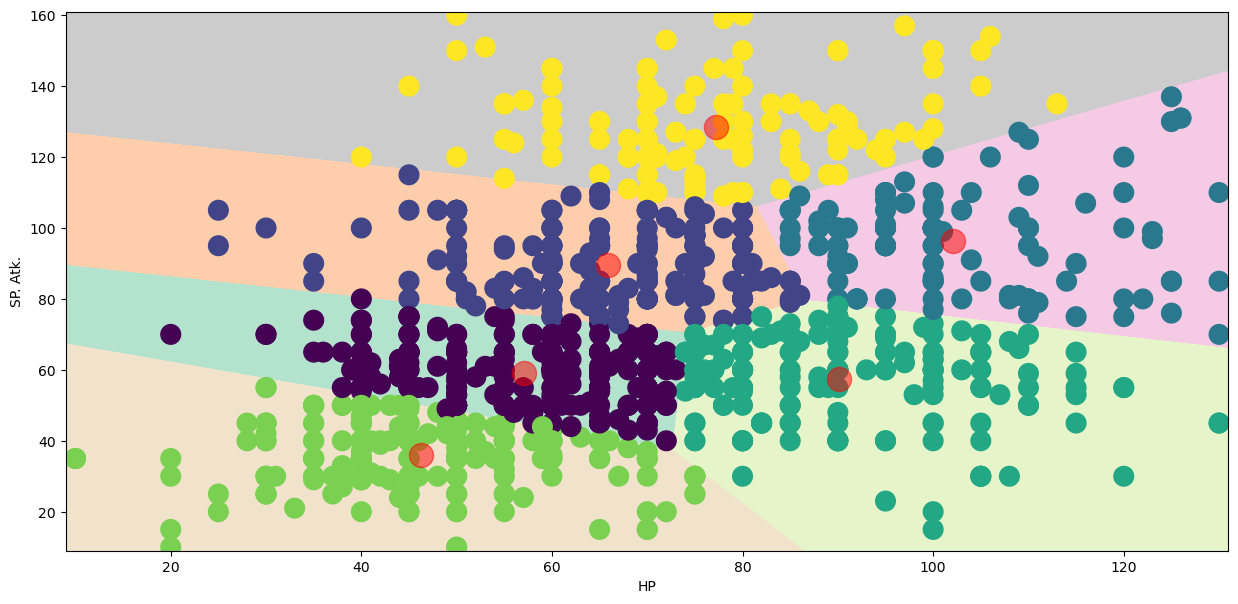

In [74]:
algorithm = (KMeans(n_clusters = 6, init='k-means++', n_init = 10, max_iter = 300,
                        tol=0.0001,  random_state= 111, algorithm='elkan') )
algorithm.fit(X3)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X3[:, 0].min() - 1, X3[:, 0].max() + 1
y_min, y_max = X3[:, 1].min() - 1, X3[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x='HP', y ='SP. Atk.', data = df, c = labels1, s = 200)
plt.scatter(x = centroids1[: , 0], y = centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('HP')
plt.ylabel('SP. Atk.')
plt.show()

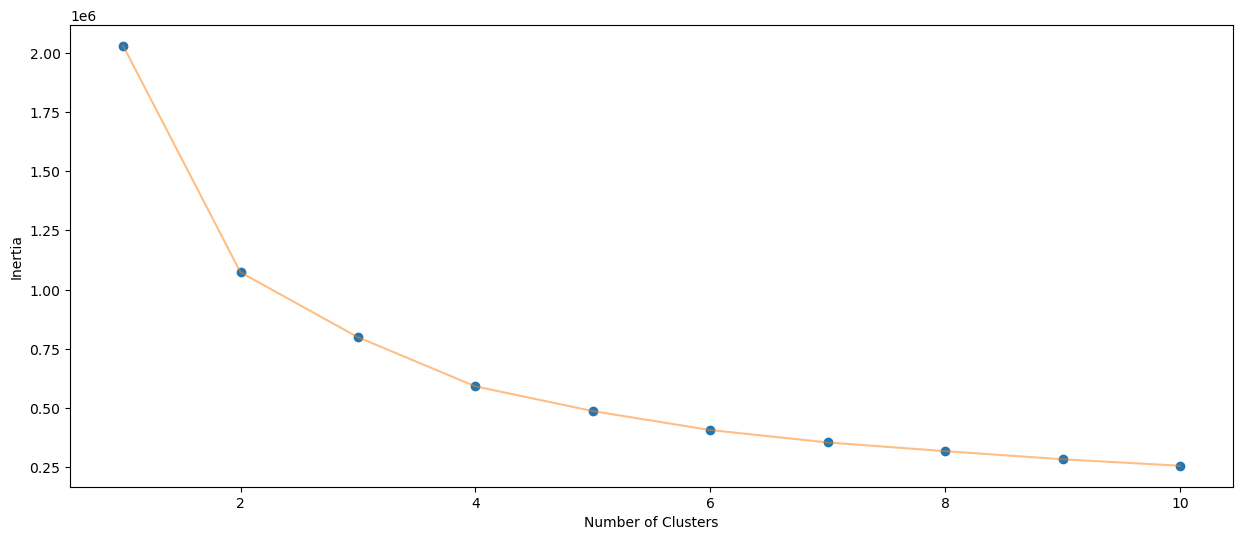

In [75]:
X4 = df[['Attack', 'Speed']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='lloyd') )
    algorithm.fit(X4)
    inertia.append(algorithm.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

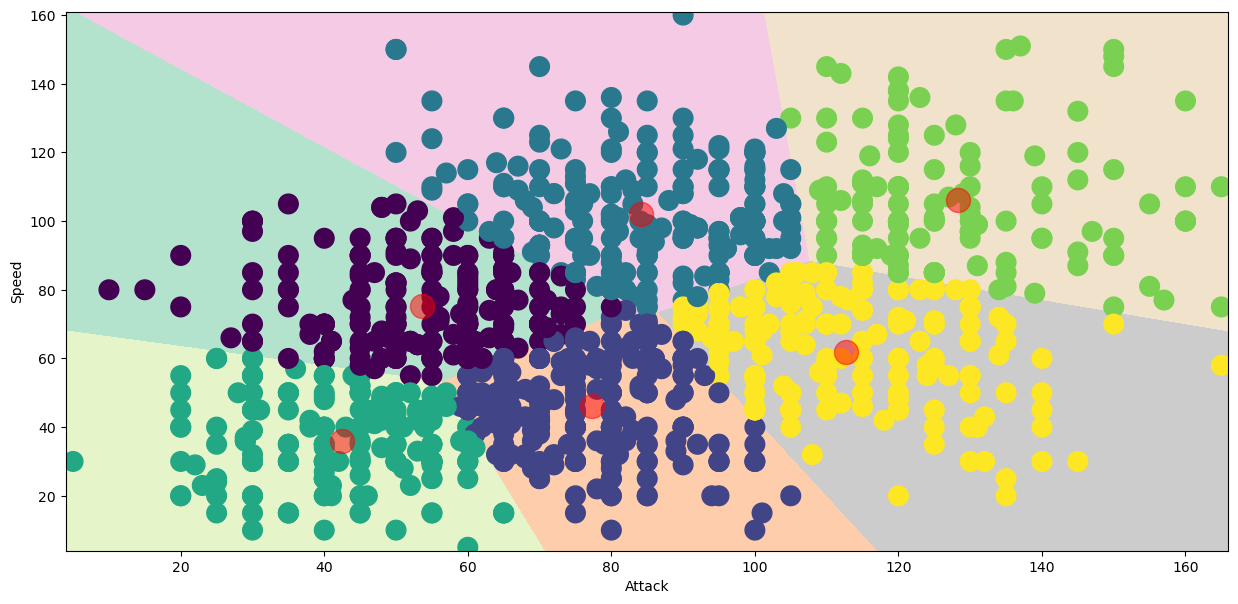

In [76]:
algorithm = (KMeans(n_clusters = 6, init='k-means++', n_init = 10, max_iter = 300,
                        tol=0.0001,  random_state= 111, algorithm='elkan') )
algorithm.fit(X4)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X4[:, 0].min() - 1, X4[:, 0].max() + 1
y_min, y_max = X4[:, 1].min() - 1, X4[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x='Attack', y ='Speed', data = df, c = labels1, s = 200)
plt.scatter(x = centroids1[: , 0], y = centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Attack')
plt.ylabel('Speed')
plt.show()

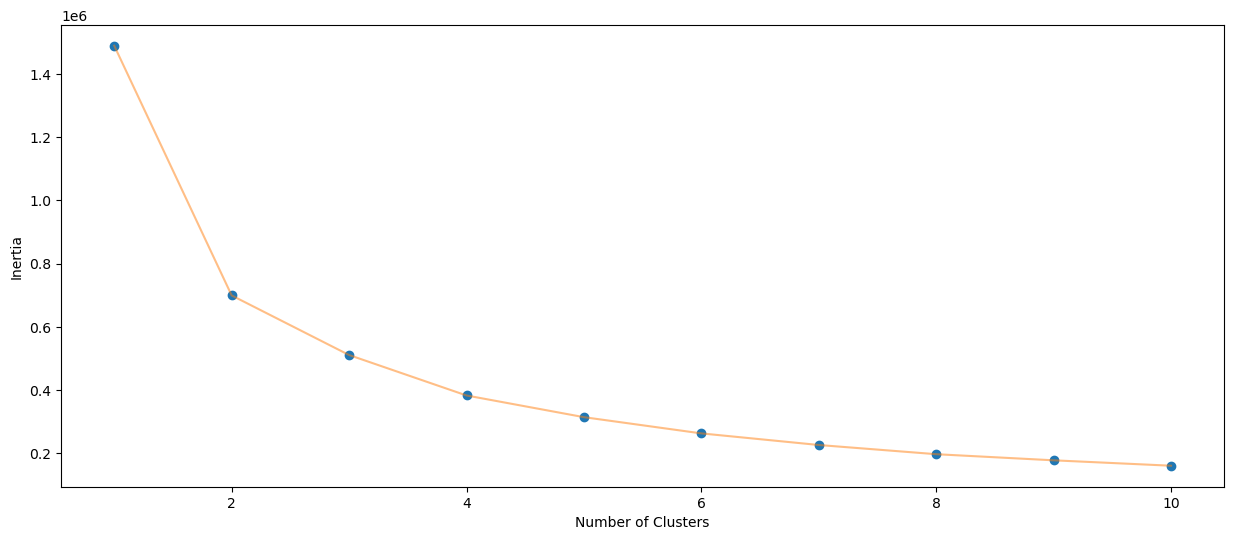

In [77]:
X5 = df[['Defense', 'SP. Def']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='lloyd') )
    algorithm.fit(X5)
    inertia.append(algorithm.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

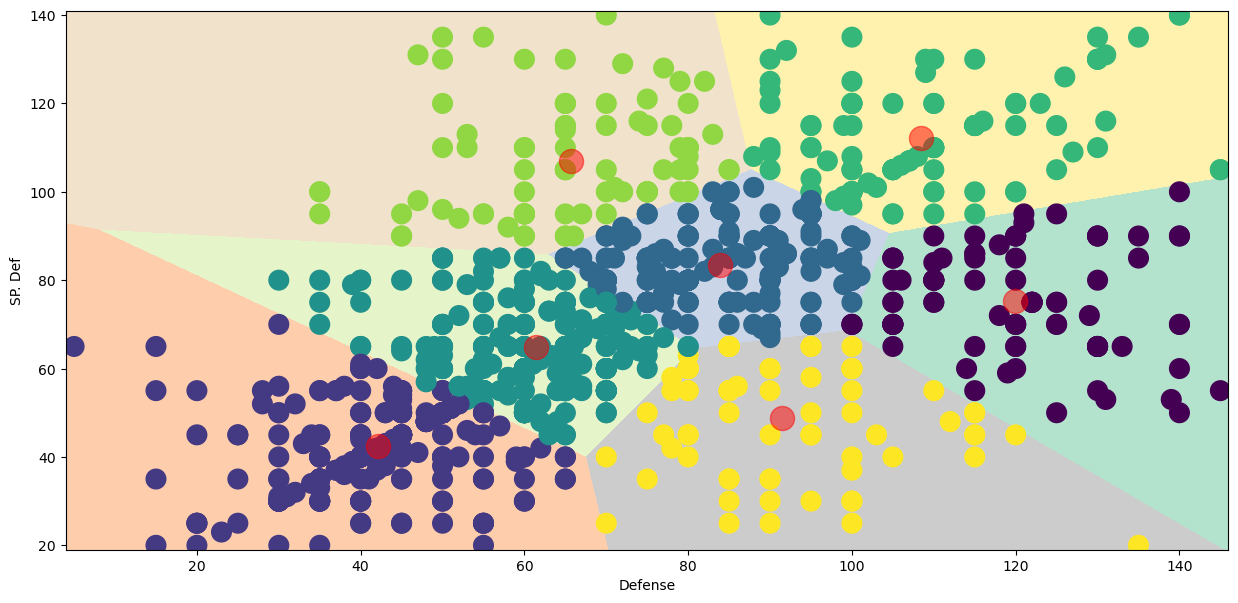

In [78]:
algorithm = (KMeans(n_clusters = 7, init='k-means++', n_init = 10, max_iter = 300,
                        tol=0.0001,  random_state= 111, algorithm='elkan') )
algorithm.fit(X5)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X5[:, 0].min() - 1, X5[:, 0].max() + 1
y_min, y_max = X5[:, 1].min() - 1, X5[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x='Defense', y ='SP. Def', data = df, c = labels1, s = 200)
plt.scatter(x = centroids1[: , 0], y = centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Defense')
plt.ylabel('SP. Def')
plt.show()

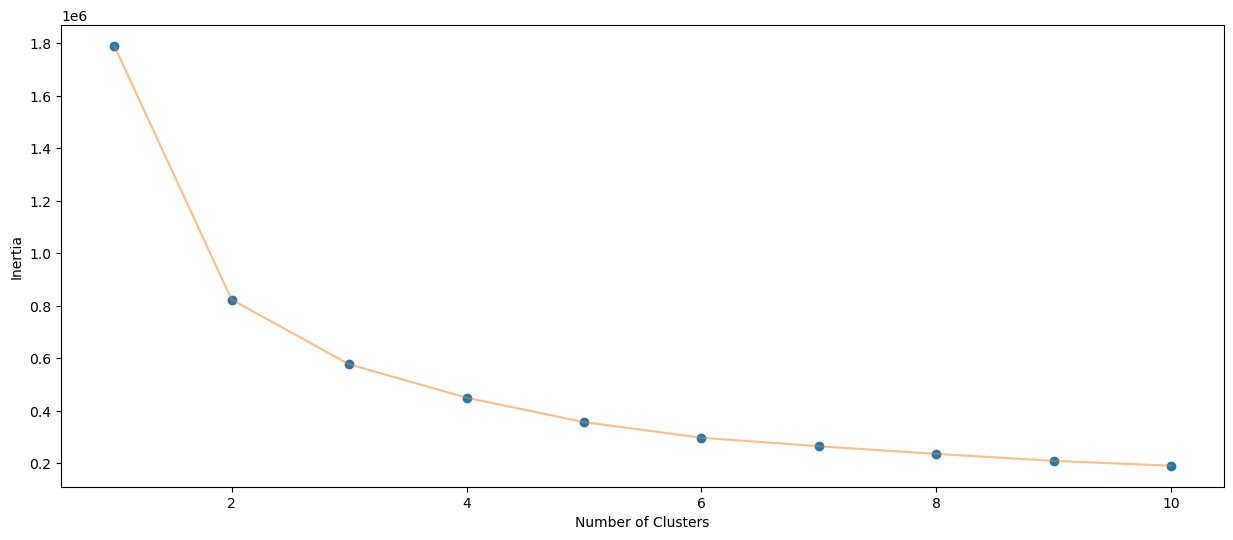

In [79]:
X6 = df[['SP. Atk.', 'SP. Def']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='lloyd') )
    algorithm.fit(X6)
    inertia.append(algorithm.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

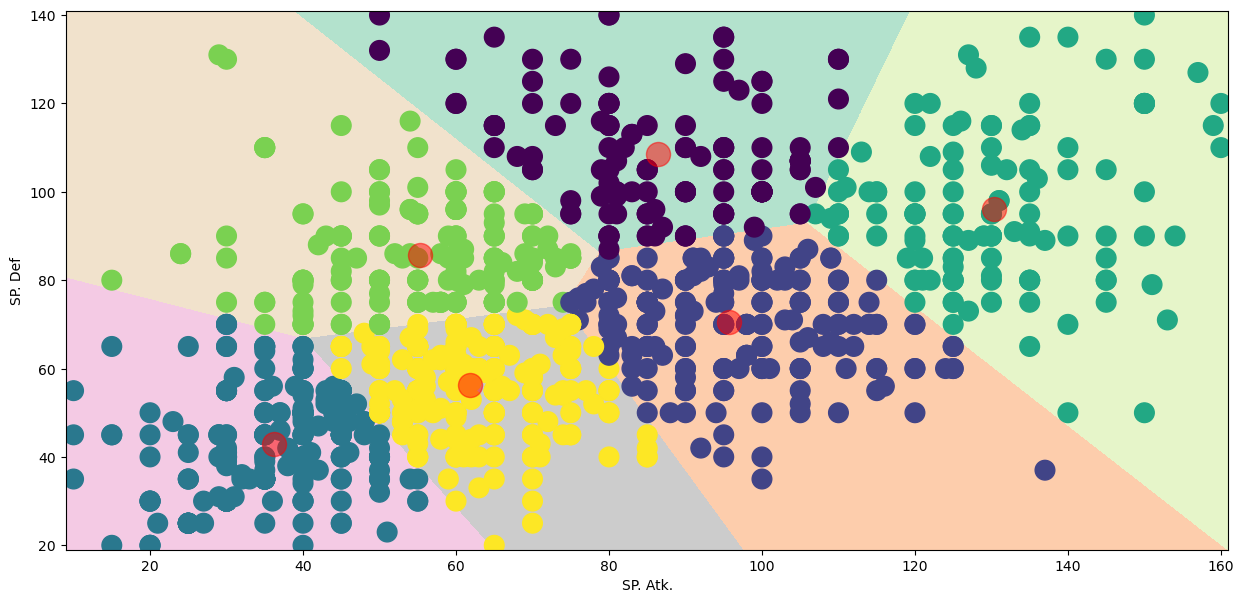

In [80]:
algorithm = (KMeans(n_clusters = 6, init='k-means++', n_init = 10, max_iter = 300,
                        tol=0.0001,  random_state= 111, algorithm='elkan') )
algorithm.fit(X6)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X6[:, 0].min() - 1, X6[:, 0].max() + 1
y_min, y_max = X6[:, 1].min() - 1, X6[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x='SP. Atk.', y ='SP. Def', data = df, c = labels1, s = 200)
plt.scatter(x = centroids1[: , 0], y = centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('SP. Atk.')
plt.ylabel('SP. Def')
plt.show()